### Import Lib

In [1]:
from _plotly_future_ import v4_subplots

In [2]:
import numpy as np
import pandas as pd 
import os
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

#for visualization
import matplotlib.pyplot as plt
from PIL import  Image
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

### Data Manipulation

In [6]:
#replaces spaces with NaN
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)

df = df[df["TotalCharges"].notnull()]
df =df.reset_index()[df.columns]
df['TotalCharges']= df['TotalCharges'].astype(float)

#Replace Long sentence with short 'NO'
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

#Replace Y/N with Binary
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})

#Function to populate new columns based on the Tenure Column
def tenure_lab(df) :
    
    if df["tenure"] <= 12 :
        return "Tenure_0-12"
    elif (df["tenure"] > 12) & (df["tenure"] <= 24 ):
        return "Tenure_12-24"
    elif (df["tenure"] > 24) & (df["tenure"] <= 48) :
        return "Tenure_24-48"
    elif (df["tenure"] > 48) & (df["tenure"] <= 60) :
        return "Tenure_48-60"
    elif df["tenure"] > 60 :
        return "Tenure_gt_60"
df["tenure_group"] = df.apply(lambda df:tenure_lab(df),
                                      axis = 1)


In [7]:
#Assign ID ,target, Categorical, Numerical, Binary and Multi Columns
Id_col  = ['customerID']
target_col = ["Churn"]
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
bin_cols   = df.nunique()[df.nunique() == 2].keys().tolist()
multi_cols = [i for i in cat_cols if i not in bin_cols]

### Preprocessing

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Replaces Y/N with 1&0
le = LabelEncoder()
for i in bin_cols :
    df[i] = le.fit_transform(df[i])
    
#Duplicating columns for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols )
std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = df.copy()
df = df.drop(columns = num_cols,axis = 1)
df = df.merge(scaled,left_index=True,right_index=True,how = "left")

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



## Baseline Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

#split train and test dataframe
train,test = train_test_split(df,test_size = .25 ,random_state = 111)

In [10]:
##seperating dependent and independent variables
cols    = [i for i in df.columns if i not in Id_col + target_col]
train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

In [11]:
def churnPrediction(algorithm,training_x,testing_x,training_y,testing_y,cols,cf,threshold_plot) :
    
    # model .fit() and training
    algorithm.fit(training_x,training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)

#-----------------------------------Generating Report of Model---------------------------------------------------------------
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y,predictions))
    print ("Accuracy   Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
#-------------------------------------------Plot Confusion Matrix--------------------------------------------------------

    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["Not churn","Churn"],
                        y = ["Not churn","Churn"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
#-------------------------------------------Plot ROC and AUC graph--------------------------------------------------------
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
#---------------------------------------fetaures importance graph--------------------------------------------------------
    # coeff(cf) => Coefficients for Logistic regression and Features for Tree Decision Model
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
#----------------------------------------------------------------------------------------------------------------------------
    
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    py.iplot(fig)
    
    #-----------Plot Threshold Graph------------------------------------------
    if threshold_plot == True : 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()
        


### 1. Logistic Regression 

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1268
           1       0.69      0.53      0.60       490

   micro avg       0.80      0.80      0.80      1758
   macro avg       0.76      0.72      0.73      1758
weighted avg       0.79      0.80      0.79      1758

Accuracy   Score :  0.8026166097838453
Area under curve :  0.7185443893645785 



C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\uti

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\fsjde\Anaconda3.1\lib\site-packages\sklearn\uti

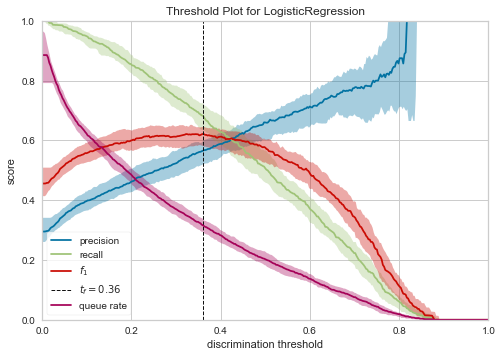

In [12]:
logit  = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

churnPrediction(logit,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

In [13]:
#Variation from other example (Variation B)
logitB= LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalaty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

churnPrediction(logitB,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

TypeError: __init__() got an unexpected keyword argument 'l1_ratio'

### 2.0 SMOTE (Synthetic Minority Over-sampling TEchnique: Random pick from minority to equlize the size of majority)

In [ ]:
from imblearn.over_sampling import SMOTE

cols    = [i for i in df.columns if i not in Id_col+target_col]

#don't smote directly, smote on the splitted dataframe
smote_X = df[cols]
smote_Y = df[target_col]

#Split train and test data
smote_train_X,smote_test_X,smote_train_Y,smote_test_Y = train_test_split(smote_X,smote_Y,
                                                                         test_size = .25 ,
                                                                         random_state = 111)

#oversampling minority class using smote
os = SMOTE(random_state = 0)
os_smote_X,os_smote_Y = os.fit_sample(smote_train_X,smote_train_Y)
os_smote_X = pd.DataFrame(data = os_smote_X,columns=cols)
os_smote_Y = pd.DataFrame(data = os_smote_Y,columns=target_col)
###



logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

churnPrediction(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

In [ ]:
#SMOTE with Variation B
logit_smoteB = LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
churnPrediction(logit_smoteB,train_X,test_X,train_Y,test_Y,
                         cols,"coefficients",threshold_plot = True)

### 3.0 Recursive Feature Elimination (RFE)

In [ ]:
from sklearn.feature_selection import RFE

logit = LogisticRegression()


rfe = RFE(logit,10)
rfe = rfe.fit(os_smote_X,os_smote_Y.values.ravel())

rfe.support_
rfe.ranking_

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support" :rfe.support_,
                       "columns" : [i for i in df.columns if i not in Id_col + target_col],
                       "ranking" : rfe.ranking_,
                      })


cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()


#split data
train_rf_X = os_smote_X[cols]
train_rf_Y = os_smote_Y
test_rf_X  = test[cols]
test_rf_Y  = test[target_col]

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#applying model
churnPrediction(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

tab_rk = ff.create_table(idc_rfe)
py.iplot(tab_rk)

In [ ]:
#RFE with Variation B
logit_rfeB = LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
#applying model
churnPrediction(logit_rfeB,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                         cols,"coefficients",threshold_plot = True)

## 3.1 Feature Extraction with Univariate Statistical Tests (Chi-squared for classification) from Kaggle/PavanRaj

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#select columns
cols = [i for i in df.columns if i not in Id_col + target_col ]

#dataframe with non negative values
df_x = df_telcom_og[cols]
df_y = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2,k = 3)
fit    = select.fit(df_x,df_y)

#Summerize scores
print ("scores")
print (fit.scores_)
print ("P - Values")
print (fit.pvalues_)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",
                                  line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",
                              line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

### 4.Decision Tree

In [ ]:
# Uses the top 3 numerical and categorical features
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from graphviz import Source
from IPython.display import SVG,display

features_cat  = score[score["feature_type"] == "Categorical"]["features"][:3].tolist()
features_num  = score[score["feature_type"] == "Numerical"]["features"][:3].tolist()

In [ ]:
#Plotting Decision Tree Graph Function
def plot_decision_tree(columns,maximum_depth,criterion_type,
                       split_type,model_performance = None) :

    dtc_x = df_x[columns]
    dtc_y = df_y[target_col]
    
    dt_classifier = DecisionTreeClassifier(max_depth = maximum_depth,
                                           splitter  = split_type,
                                           criterion = criterion_type,
                                          )
    dt_classifier.fit(dtc_x,dtc_y)
    

    graph = Source(tree.export_graphviz(dt_classifier,out_file=None,
                                        rounded=True,proportion = False,
                                        feature_names = columns, 
                                        precision  = 2,
                                        class_names=["Not churn","Churn"],
                                        filled = True))
    
    if model_performance == True :
        churnPrediction(dt_classifier,
                                 dtc_x,test_X[columns],
                                 dtc_y,test_Y,
                                 columns,"features",threshold_plot = True)
    display(graph)


In [ ]:
#Using Top 3 From Numerical Data
plot_decision_tree(features_num,3,"gini","best")

In [ ]:
#Using Top 3 From Categorical Data
plot_decision_tree(features_cat,3,"entropy","best",
                   model_performance = True ,)
print(features_cat, features_num)


In [ ]:
#using contract,tenure and paperless billing variables
columns = ['tenure','Contract_Month-to-month', 'PaperlessBilling',
           'Contract_One year', 'Contract_Two year']

plot_decision_tree(columns,3,"gini","best",model_performance= True)

In [ ]:
#using contract,tenure and PaymentMethod_Electronic check variables
columnsB = ['tenure','Contract_Month-to-month', 'PaymentMethod_Electronic check',
           'Contract_One year', 'Contract_Two year']

plot_decision_tree(columnsB,3,"gini","best",model_performance= True)

In [ ]:
#According Correlation Heatmap
columnsC = ['Contract_Month-to-month', 'tenure_group_Tenure_0-12', 'PaperlessBilling','PaymentMethod_Electronic check', 'InternetService_Fiber optic', 'MonthlyCharges']

plot_decision_tree(columnsC,3,"gini","best",model_performance= True)

In [ ]:
#ALL COULUMNS
columnsD = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
        'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'tenure_group_Tenure_0-12', 'tenure_group_Tenure_12-24',
       'tenure_group_Tenure_24-48', 'tenure_group_Tenure_48-60',
       'tenure_group_Tenure_gt_60', 'tenure', 'MonthlyCharges',
       'TotalCharges']

plot_decision_tree(columnsD,3,"gini","best",model_performance= True)

## 4.1 Using KNN to SMOTE Oversample Data

In [ ]:
#New Function for model without Cols and Coefficients Variables
def churnPrediction1(algorithm,training_x,testing_x,
                                 training_y,testing_y,threshold_plot = True) :
    
    #model .fit() ,predictions and probabilities
        algorithm.fit(training_x,training_y)
        predictions   = algorithm.predict(testing_x)
        probabilities = algorithm.predict_proba(testing_x)

    #Report
        print (algorithm)
        print ("\n Classification report : \n",classification_report(testing_y,predictions))
        print ("Accuracy Score   : ",accuracy_score(testing_y,predictions))
        
        #confusion matrix
        conf_matrix = confusion_matrix(testing_y,predictions)
       
        #roc_auc_score
        model_roc_auc = roc_auc_score(testing_y,predictions) 
        print ("Area under curve : ",model_roc_auc)
        fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
     
    #Plot Graphs
        #plot roc curve
        trace1 = go.Scatter(x = fpr,y = tpr,
                            name = "Roc : " + str(model_roc_auc),
                            line = dict(color = ('rgb(22, 96, 167)'),width = 2),
                           )
        trace2 = go.Scatter(x = [0,1],y=[0,1],
                            line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                            dash = 'dot'))

        #plot confusion matrix(HeatMap)
        trace3 = go.Heatmap(z = conf_matrix ,x = ["Not churn","Churn"],
                            y = ["Not churn","Churn"],
                            showscale  = False,colorscale = "Blues",name = "matrix",
                            xaxis = "x2",yaxis = "y2"
                           )

        layout = go.Layout(dict(title="Model performance" ,
                                autosize = False,height = 500,width = 800,
                                showlegend = False,
                                plot_bgcolor  = "rgb(243,243,243)",
                                paper_bgcolor = "rgb(243,243,243)",
                                xaxis = dict(title = "false positive rate",
                                             gridcolor = 'rgb(255, 255, 255)',
                                             domain=[0, 0.6],
                                             ticklen=5,gridwidth=2),
                                yaxis = dict(title = "true positive rate",
                                             gridcolor = 'rgb(255, 255, 255)',
                                             zerolinewidth=1,
                                             ticklen=5,gridwidth=2),
                                margin = dict(b=200),
                                xaxis2=dict(domain=[0.7, 1],tickangle = 90,
                                            gridcolor = 'rgb(255, 255, 255)'),
                                yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                               )
                      )
        data = [trace1,trace2,trace3]
        fig = go.Figure(data=data,layout=layout)

        py.iplot(fig)

        if threshold_plot == True : 
            visualizer = DiscriminationThreshold(algorithm)
            visualizer.fit(training_x,training_y)
            visualizer.poof()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
churnPrediction1(knn,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = True)

### 4.2 Visualize Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Fuction for Random Forest
def plot_tree_randomforest(columns,nf_estimators,estimated_tree,maximum_depth,criterion_type,model_performance = None) :
    
    dataframe = df_telcom_og[columns + target_col].copy()
    
    #Assign training and test datasets
    rf_x     = dataframe[[i for i in columns if i not in target_col]]
    rf_y     = dataframe[target_col]
    
    #random forest classifier
    rfc   = RandomForestClassifier(n_estimators = nf_estimators,max_depth = maximum_depth,criterion = criterion_type)
    rfc.fit(rf_x,rf_y)
    
    estimated_tree = rfc.estimators_[estimated_tree]
    
    graph = Source(tree.export_graphviz(estimated_tree,out_file=None,
                                        rounded=True,proportion = False,
                            feature_names = columns, 
                            precision  = 2,
                            class_names=["Not churn","Churn"],
                            filled = True))
    display(graph)
    
    #model performance
    if model_performance == True :
        churnPrediction(rfc,rf_x,test_X[columns],rf_y,test_Y,columns,"features",threshold_plot = True)
        

cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
plot_tree_randomforest(cols1,100,99,3,"entropy",True)

##  4.3 <a id='5.8'>A random forest classifier.</a>
# A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement .
# Below are the trees produced by random forest model with 10 estimated trees with maximum depth of three  for each tree. Each tree produced is slightly different from other.

##### 4.3.1 10 Trees with RF

In [ ]:
n = np.arange(0,10).tolist()
cols1 = [ i for i in train_X.columns if i not in target_col + Id_col] 
for i in n :
    plot_tree_randomforest(cols1,10,i,3,"entropy",model_performance=False)

#### 4.3.2 making 10 trees with random forest for columns 
#### selected from recursive feature elimination



In [ ]:
idc_rfe[idc_rfe['rfe_support'] ==True]

In [ ]:
n = np.arange(0,10).tolist()
cols = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist() 
for i in n :
    plot_tree_randomforest(cols,10,i,3,"gini",model_performance=False)

## 5.0 Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)
churnPrediction1(gnb,os_smote_X,test_X,os_smote_Y,test_Y)

### 6.0 SVM [Support Vector Machine] 
#### In this algorithm, we plot each data item as a point in n-dimensional space .where n is number of features you have) with the value of each feature being the value of a particular coordinate. Then, we perform classification by finding the hyper-plane that differentiate the two classes


In [ ]:
from sklearn.svm import SVC

#Support vector classifierfrom sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(priors=None)

churnPrediction1(gnb,os_smote_X,test_X,os_smote_Y,test_Y)
#using linear hyper plane
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,tol=0.001, verbose=False)

cols = [i for i in df.columns if i not in Id_col + target_col]
churnPrediction(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"coefficients",threshold_plot = False)

In [ ]:
#tuning parameters for support vector machine
#Support vector clasifier
#using non-linear hyper plane("rbf")

svc_rbf  = SVC(C=1.0, kernel='rbf', 
               degree= 3, gamma=1.0, 
               coef0=0.0, shrinking=True,
               probability=True,tol=0.001,
               cache_size=200, class_weight=None,
               verbose=False,max_iter= -1,
               random_state=None)

churnPrediction1(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,threshold_plot = False)

## 7.0 Light LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

cols = [i for i in df.columns if i not in Id_col + target_col]
churnPrediction(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

## 8.0 XGBClassifier

In [ ]:
from xgboost import XGBClassifier

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)


churnPrediction(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                         cols,"features",threshold_plot = True)

# 9.0 Model Evaluations

## 9.1 Model Performance Metrics

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#gives model report in dataframe
def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X,test_X,train_Y,test_Y,
                      "Log Regres")
model1_1 = model_report(logitB,train_X,test_X,train_Y,test_Y,
                         "Log Reg B")
model2 = model_report(logit_smote,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LogReg(SMOTE)")
model2_2 = model_report(logit_smoteB,train_X,test_X,train_Y,test_Y,"LogReg(SMOTE)B")

model3 = model_report(logit_rfe,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "LogReg(RFE)")
model3_3 = model_report(logit_rfeB,train_rf_X,test_rf_X,train_rf_Y,test_rf_Y,
                      "LogReg(RFE)B")

decision_tree = DecisionTreeClassifier(max_depth = 9,
                                       random_state = 123,
                                       splitter  = "best",
                                       criterion = "gini",
                                      )
model4 = model_report(decision_tree,train_X,test_X,train_Y,test_Y,
                      "Decision Tree")
model5 = model_report(knn,os_smote_X,test_X,os_smote_Y,test_Y,
                      "KNN Classifier")
rfc = RandomForestClassifier(n_estimators = 1000,
                             random_state = 123,
                             max_depth = 9,
                             criterion = "gini")
model6 = model_report(rfc,train_X,test_X,train_Y,test_Y,
                      "Random Forest Classifier")
model7 = model_report(gnb,os_smote_X,test_X,os_smote_Y,test_Y,
                      "Naive Bayes")
model8 = model_report(svc_lin,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier Linear")
model9 = model_report(svc_rbf,os_smote_X,test_X,os_smote_Y,test_Y,
                      "SVM Classifier RBF")
model10 = model_report(lgbm_c,os_smote_X,test_X,os_smote_Y,test_Y,
                      "LGBM Classifier")
model11 = model_report(xgc,os_smote_X,test_X,os_smote_Y,test_Y,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,model1_1,model2,model2_2,model3,model3_3,
                                model4,model5,model6,
                                model7,model8,model9,
                                model10,model11],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

In [ ]:
#Compare Model Metrices
model_performances
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

In [ ]:
##Compare Model Confusion Matrix
lst    = [logit,logitB,logit_smote,logit_smoteB,decision_tree,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression(Baseline_model)','Logistic Regression(Baseline_model) variation B','Logistic Regression(SMOTE)','Logistic Regression(SMOTE) Var. B',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

In [ ]:
## Compare ROC of models
plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(test_Y,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

In [ ]:
## Precision Recall Curves
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


fig = plt.figure(figsize=(13,17))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    recall,precision,thresholds = precision_recall_curve(test_Y,probabilities[:,1])
    plt.plot(recall,precision,linewidth = 1.5,
             label = ("avg_pcn : " + 
                      str(np.around(average_precision_score(test_Y,predictions),3))))
    plt.plot([0,1],[0,0],linestyle = "dashed")
    plt.fill_between(recall,precision,alpha = .2)
    plt.legend(loc = "lower left",
               prop = {"size" : 10})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xlabel("recall",fontsize =7)
    plt.ylabel("precision",fontsize =7)
    plt.xlim([0.25,1])
    plt.yticks(np.arange(0,1,.3))